# PyGplates

This notebook uses PyGplates to generate data files that will be used in our main notebook. To run this notebook, use the [instructions linked here](https://github.com/GPlates/pygplates-tutorials) to set up a docker container for PyGplates. 

# Imports and Helper Functions

In [3]:
import json
import pygplates
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from scipy.spatial.transform import Rotation as R
%matplotlib notebook

from pathlib import Path
mainDir = Path(".").parent.absolute().parent.absolute()

#Coordinate transformation from spherical polar to cartesian
def polarToCartesian(radius, theta, phi, useLonLat=True):
    if useLonLat == True:
        theta, phi = np.radians(theta+180.), np.radians(90. - phi)
    X = radius * np.cos(theta) * np.sin(phi)
    Y = radius * np.sin(theta) * np.sin(phi)
    Z = radius * np.cos(phi)
    
    #Return data either as a list of XYZ coordinates or as a single XYZ coordinate
    if (type(X) == np.ndarray):
        return np.stack((X, Y, Z), axis=1)
    else:
        return np.array([X, Y, Z])

#Coordinate transformation from cartesian to polar
def cartesianToPolarCoords(XYZ, useLonLat=True):
    X, Y, Z = XYZ[:, 0], XYZ[:, 1], XYZ[:, 2]
    R = (X**2 + Y**2 + Z**2)**0.5
    theta = np.arctan2(Y, X)
    phi = np.arccos(Z / R)
    
    #Return results either in spherical polar or leave it in radians
    if useLonLat == True:
        theta, phi = np.degrees(theta), np.degrees(phi)
        lon, lat = theta - 180, 90 - phi
        lon[lon < -180] = lon[lon < -180] + 360
        return R, lon, lat
    else:
        return R, theta, phi

# Read NPZ files for Icosphere data
def getIcosphere(subdivisions=4):
    fileDir = str(mainDir) + '/Data/SpheresNPZ/IcosphereSubs{}.npz'.format(subdivisions)
    data = np.load(fileDir)
    return data['vertices'], data['cells']

# PlateIDs

The code bellow uses PyGplates to calculate plate IDs of some points.

<IPython.core.display.Javascript object>


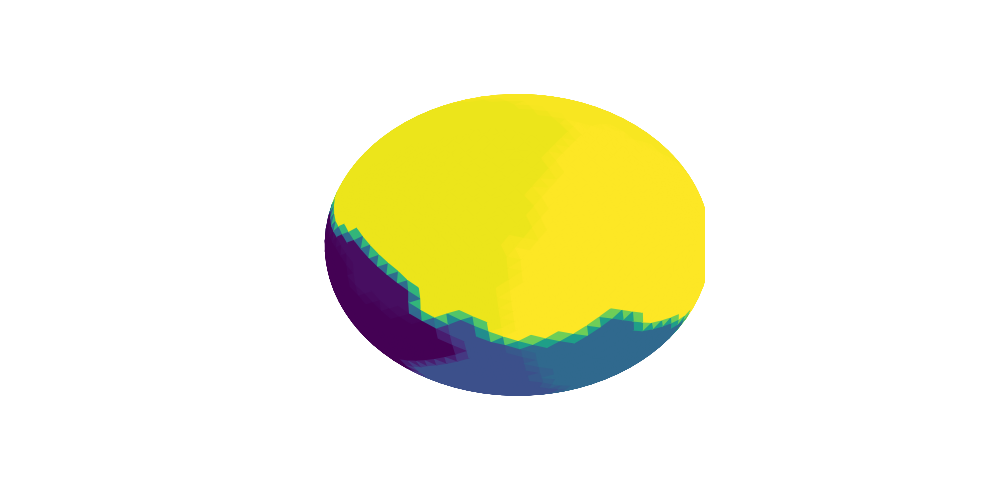

In [4]:
#Creates a list of point features for each vertex on our sphere
def createPointFeatures(lon, lat):
    pointsOnSphere = [pygplates.PointOnSphere(float(lat[i]), float(lon[i])) for i in range(len(lon))]
    pointFeatures = []
    for point in pointsOnSphere:
        pointFeature = pygplates.Feature()
        pointFeature.set_geometry(point)
        pointFeatures.append(pointFeature)
    return pointFeatures

# Assigns plate IDs to points on icosphere
class PlateIdentifyier:
    def __init__(self, subdivisions=4):
        self.platePolyFileDir = './Data/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies_PMAG.gpmlz'
        self.rotationsFileDir = './Data/Matthews_etal_GPC_2016_410-0Ma_GK07_PMAG.rot'
        self.subdivisions = subdivisions
        
        # Read icosphere file and get lon lat coords
        self.verts, self.cells = getIcosphere(subdivisions=subdivisions)
        r, lon, lat = cartesianToPolarCoords(self.verts)
        self.pointFeats = createPointFeatures(lon, lat)
        
    def getPlateIDs(self, time):
        assignedPointFeatures = pygplates.partition_into_plates(
            self.platePolyFileDir,
            self.rotationsFileDir,
            self.pointFeats,
            reconstruction_time=float(time),
            properties_to_copy = [
                pygplates.PartitionProperty.reconstruction_plate_id,
                pygplates.PartitionProperty.valid_time_period])
        featureIds = [feat.get_reconstruction_plate_id() for feat in assignedPointFeatures]
        return np.array(featureIds)
        
P = PlateIdentifyier(subdivisions=4)
plateIds = P.getPlateIDs(200)

# Set colors
c = np.mean(plateIds[P.cells], axis=1)
norm = plt.Normalize(c.min(), c.max())
colors = plt.cm.viridis(norm(c))

# Plot sphere
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection="3d")
pc = art3d.Poly3DCollection(P.verts[P.cells], color=colors)
ax.add_collection(pc)

ax.grid(False)
ax.set_xlim3d(-0.8, 0.8)
ax.set_ylim3d(-0.8, 0.8)
ax.set_zlim3d(-0.8, 0.8)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')
plt.show()

We can then use the code bellow to automatically generate NPZ files of plate ids for a given icosphere at various time steps.

In [ ]:
if False:
    saveDirFormat = './PlateIDs/Sub{}/Time{}.npz'

    # Create plate ID identifyer
    P = PlateIdentifyier(subdivisions=7)

    for time in range(201):
        plateIds = P.getPlateIDs(time)
        saveDir = saveDirFormat.format(P.subdivisions, time)
        np.savez(saveDir, ids=plateIds)

# Rotations

In [5]:
class Rotations:
    def __init__(self):
        self.rotationsFileDir = './Data/Matthews_etal_GPC_2016_410-0Ma_GK07_PMAG.rot'
        self.rotationModel = pygplates.RotationModel(self.rotationsFileDir)

    #Get stage rotation data from pygplates and return a scipy rotation
    def getRotations(self, time, deltaTime, plateIds):
        axii, angles = {}, {}
        for plateId in np.unique(plateIds):
            stageRotation = self.rotationModel.get_rotation(int(time-deltaTime), int(plateId), int(time))
            stageRotation = stageRotation.get_euler_pole_and_angle()

            #Create rotation quaternion from axis and angle
            axisLatLon = stageRotation[0].to_lat_lon()
            axii[int(plateId)] = list(polarToCartesian(1, axisLatLon[1], axisLatLon[0]))
            angles[int(plateId)] = stageRotation[1]
        
        # Put axii and angles into a dictionary
        rotationsDict = {
            'axii' : axii,
            'angles' : angles
        }
        return rotationsDict

if False:
    time = 200
    deltaTime = 1
    P = PlateIdentifyier(subdivisions=7)
    rots = Rotations()

    rotations = {}
    for time in range(201):
        print(time)
        plateIds = P.getPlateIDs(time)
        rotations[int(time)] = rots.getRotations(time, deltaTime, plateIds)

    # Write data as JSON
    rotJson = json.dumps(rotations)
    f = open("PlateRotations.json", "w")
    f.write(rotJson)
    f.close()

# Plate Boundarie